# Model Testing

Here we will test different models to see which one performs best on our data. We will test different models:


We will work on already prepared dataset.

In [41]:
import pandas as pd
import data_preprocessing as dp

jobs_df = pd.read_csv('data/cleared/linkedin_data.csv')

# Dropping unnecessary columns
jobs_df = jobs_df.drop(['Flw_Cnt', 'Job_Desc', 'Job_Ttl', 'max_sal', 'min_sal', 'Co_Nm', 'py_prd', 'loc'], axis=1)

print(jobs_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          12491 non-null  int64  
 1   Is_Supvsr      12491 non-null  bool   
 2   med_sal        12491 non-null  float64
 3   wrk_typ        12491 non-null  object 
 4   st_code        12491 non-null  object 
 5   is_remote      12491 non-null  int64  
 6   views          12491 non-null  int64  
 7   xp_lvl         12491 non-null  object 
 8   mean_year_sal  12491 non-null  float64
 9   Topic_1        12491 non-null  float64
 10  Topic_2        12491 non-null  float64
 11  Topic_3        12491 non-null  float64
 12  Topic_4        12491 non-null  float64
 13  Topic_5        12491 non-null  float64
 14  Topic_6        12491 non-null  float64
 15  Topic_7        12491 non-null  float64
 16  Topic_8        12491 non-null  float64
 17  Topic_9        12491 non-null  float64
dtypes: boo

### Data Preparation


In [42]:
from sklearn.model_selection import train_test_split
import numpy as np

mean_sal_by_xp_lvl = jobs_df.groupby('xp_lvl')['med_sal'].mean()
mean_sal_by_st_code = jobs_df.groupby('st_code')['med_sal'].mean()
mean_sal_by_wrk_type = jobs_df.groupby('wrk_typ')['med_sal'].mean() 

jobs_df['mean_sal_by_st_code'] = jobs_df['st_code'].map(mean_sal_by_st_code)
jobs_df['mean_sal_by_xp_lvl'] = jobs_df['xp_lvl'].map(mean_sal_by_xp_lvl)
jobs_df['mean_sal_by_wrk_type'] = jobs_df['wrk_typ'].map(mean_sal_by_wrk_type)

useful_columns = ['Is_Supvsr', 'is_remote', 'views', 'mean_sal_by_st_code', 'mean_sal_by_xp_lvl', 'mean_sal_by_wrk_type']
topic_columns = [col for col in jobs_df.columns if col.startswith('Topic_')]

y = jobs_df['med_sal'].values
X = jobs_df[useful_columns].values
X_with_topics = jobs_df[useful_columns + topic_columns].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_topics_train, X_topics_test, y_topics_train, y_topics_test = train_test_split(X_with_topics, y, test_size=0.25, random_state=0)

## K Neighbors Regressor

In [44]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

scaler = StandardScaler() 
X_topics_train_scaled = scaler.fit_transform(X_topics_train)
X_topics_test_scaled = scaler.transform(X_topics_test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_topics_train_scaled = scaler.transform(y_topics_train.reshape(-1, 1))

def knn_regressor(X_train, X_test, y_train, y_test):
    regressor = KNeighborsRegressor(n_neighbors=5, metric='minkowski', p=2)
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_pred = y_pred.flatten()

    scores = cross_val_score(regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    rmse_scores = np.sqrt(-scores)

    k_range = list(range(1, 31))
    weight_options = ['uniform', 'distance']
    metric_options = ['euclidean', 'manhattan', 'minkowski']

    param_grid = dict(n_neighbors=k_range, weights=weight_options, metric=metric_options)

    grid = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

    grid.fit(X_train, y_train.ravel())

    print(f" RMSE: {np.sqrt(-grid.best_score_)}")
    print(f" Best parameters: {grid.best_params_}")
    print(f" Best estimator: {grid.best_estimator_}")

    # Use the best estimator from the grid search to make predictions
    best_regressor = grid.best_estimator_
    y_pred_best = best_regressor.predict(X_test)

    # Reshape y_pred_best to a 2D array and inverse transform
    y_pred_best = y_pred_best.reshape(-1, 1)
    y_pred_best = scaler.inverse_transform(y_pred_best)
    y_pred_best = y_pred_best.flatten()

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred_best)
    mse = mean_squared_error(y_test, y_pred_best)
    r2 = r2_score(y_test, y_pred_best)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse)}")
    print(f"R-squared Score (R2): {r2}")

    return grid, y_pred_best

print("KNN Regressor without topics")
gird, y_pred_best = knn_regressor(X_train_scaled, X_test_scaled, y_train_scaled, y_test)
print("\nKNN Regressor with topics")
grid_topics, y_pred_topics_best = knn_regressor(X_topics_train_scaled, X_topics_test_scaled, y_topics_train_scaled, y_topics_test)

KNN Regressor without topics
 RMSE: 0.8399679063824868
 Best parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
 Best estimator: KNeighborsRegressor(metric='manhattan', n_neighbors=29)
Mean Absolute Error (MAE): 28126.67202755971
Mean Squared Error (MSE): 1253921420.3288238
Root Mean Squared Error (RMSE): 35410.752891301585
R-squared Score (R2): 0.29078193020635446

KNN Regressor with topics
 RMSE: 0.7679874368709344
 Best parameters: {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'distance'}
 Best estimator: KNeighborsRegressor(metric='manhattan', n_neighbors=27, weights='distance')
Mean Absolute Error (MAE): 24392.434915142854
Mean Squared Error (MSE): 1006100422.1863493
Root Mean Squared Error (RMSE): 31719.086086871248
R-squared Score (R2): 0.4309495093763873


KNN Regressor without topics


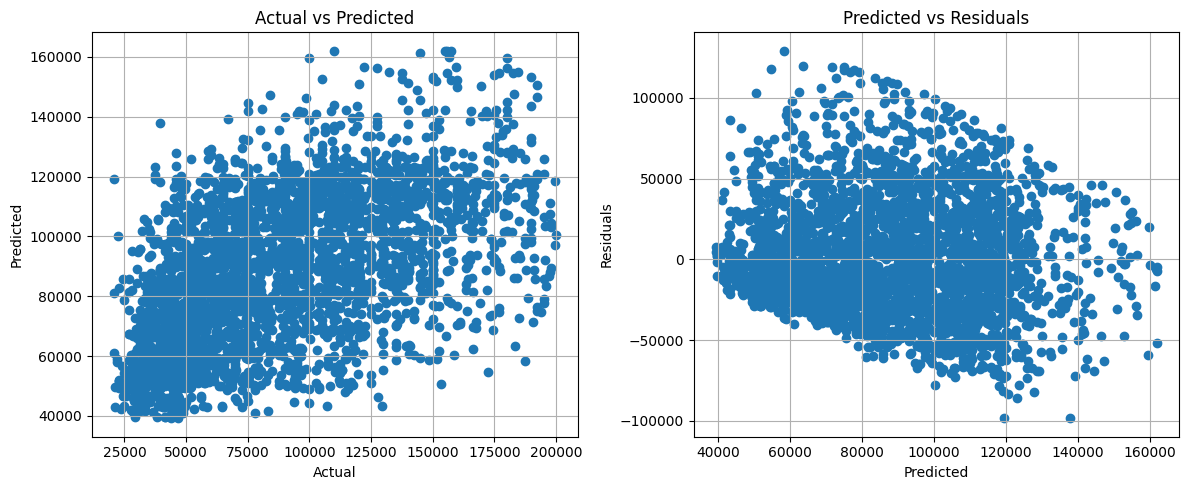


KNN Regressor with topics


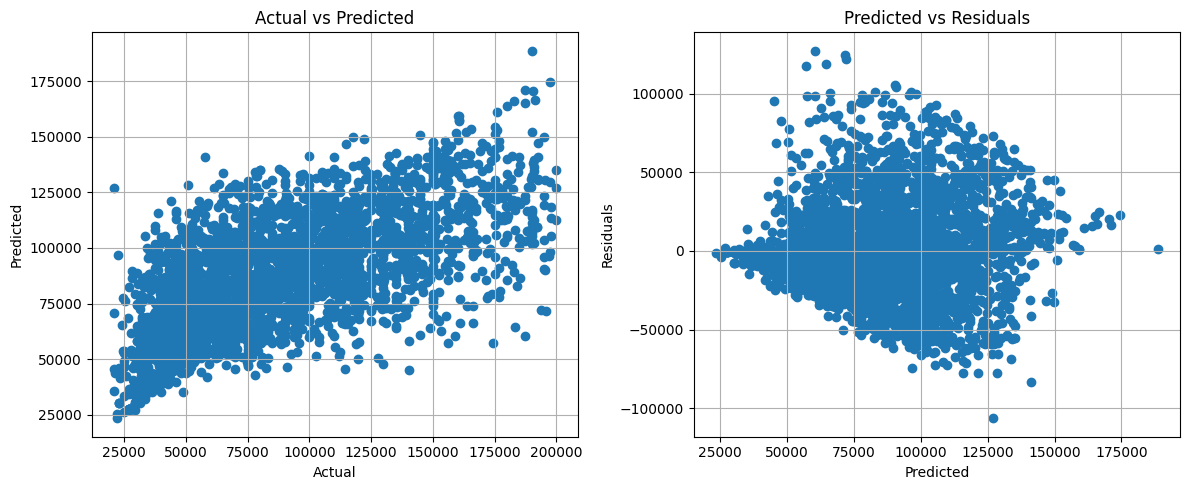

In [51]:
import matplotlib.pyplot as plt

def plot_predicted_knn_regressor(grid, X_test, y_test):
    # Use the best estimator from the grid search to make predictions
    best_regressor = grid.best_estimator_
    y_pred_best = best_regressor.predict(X_test)

    # Reshape y_pred_best to a 2D array
    y_pred_best = y_pred_best.reshape(-1, 1)

    y_pred_best = scaler.inverse_transform(y_pred_best)
    y_pred_best = y_pred_best.flatten()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot predicted vs actual values
    axes[0].scatter(y_test, y_pred_best)
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title('Actual vs Predicted')
    axes[0].grid(True)

    # Plot residuals
    axes[1].scatter(y_pred_best, y_test - y_pred_best)
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Predicted vs Residuals')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

print("KNN Regressor without topics")
plot_predicted_knn_regressor(grid, X_test_scaled, y_test)
print("\nKNN Regressor with topics")
plot_predicted_knn_regressor(grid_topics, X_topics_test_scaled, y_topics_test)

The provided Python code is performing a regression task using a K-Nearest Neighbors (KNN) model to predict median salaries based on several job features. The code includes data preprocessing (such as feature scaling and splitting the data into training and testing sets), model training, prediction, and evaluation using Mean Squared Error (MSE) and cross-validation.

## Comments on the results

The evaluation metrics you've calculated provide a mixed picture of the model's performance:

1. **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual values is approximately 26798. This means that on average, model's predictions are about $26798 off from the actual values.

2. **Root Mean Squared Error (RMSE):** The RMSE is approximately 34508, which is higher than the MAE. This indicates that the model has made some predictions that are significantly off from the actual values, as the RMSE is more sensitive to large errors.

3. **R-squared Score (R2):** The R2 score is approximately 0.312, which means that about 31.2% of the variability in the target variable can be explained by the model. This isn't a very high R2 score, suggesting that the model doesn't explain a large portion of the variability in the data.



# Decision Tree Regression

In [59]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_regressor(X_train, X_test, y_train, y_test):
    param_grid = {
        'max_depth': [None, 2, 5, 7, 10, 14, 20, 30],
        'min_samples_split': [20, 50, 80, 100, 200, 400],
        'min_samples_leaf': [20, 50, 80, 100, 200, 400],
    }

    regressor = DecisionTreeRegressor(random_state=0)

    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    print('Best parameters: ', grid_search.best_params_)

    best_regressor = grid_search.best_estimator_

    y_pred = best_regressor.predict(X_test)
    print('Mean squared error: ', mean_squared_error(y_test, y_pred))

    scores = cross_val_score(best_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    rmse_scores = np.sqrt(-scores)

    print('RMSE scores: ', rmse_scores)
    print('Mean RMSE: ', rmse_scores.mean())
    print('Standard deviation of RMSE: ', rmse_scores.std())
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

    return y_pred

print("Decision Tree Regressor without topics")
y_pred = decision_tree_regressor(X_train_scaled, X_test_scaled, y_train_scaled, y_test)
print("\nDecision Tree Regressor with topics")
y_pred_topics = decision_tree_regressor(X_topics_train_scaled, X_topics_test_scaled, y_topics_train_scaled, y_topics_test)

Decision Tree Regressor without topics
Best parameters:  {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 200}
Mean squared error:  9553475531.216484
RMSE scores:  [0.8440739  0.83164134 0.8257356  0.83257843 0.86110207]
Mean RMSE:  0.8390262686286455
Standard deviation of RMSE:  0.01253453965925853
MAE: 88235.30040287893

Decision Tree Regressor with topics
Best parameters:  {'max_depth': None, 'min_samples_leaf': 50, 'min_samples_split': 200}
Mean squared error:  9553470031.17713
RMSE scores:  [0.84107747 0.83261509 0.83167116 0.83867587 0.84797263]
Mean RMSE:  0.8384024447890486
Standard deviation of RMSE:  0.005960246925653576
MAE: 88235.2911416504


Decision Tree Regressor without topics


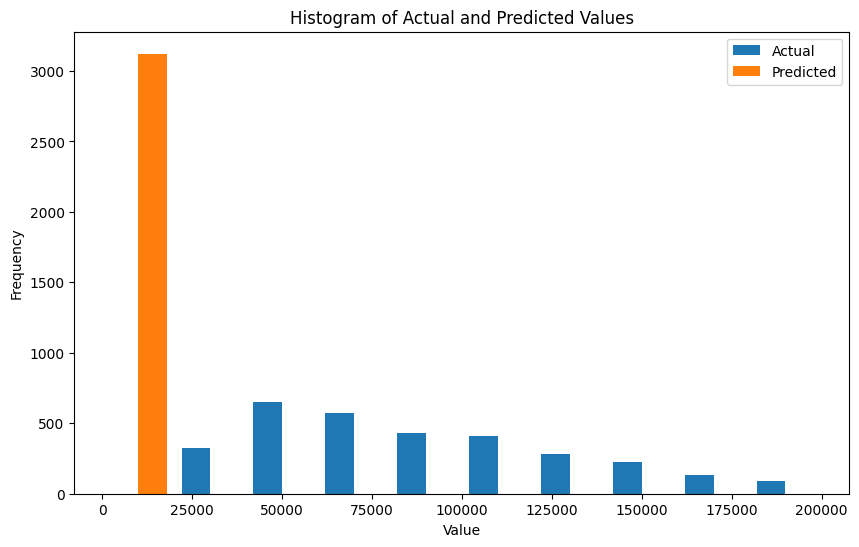


Decision Tree Regressor with topics


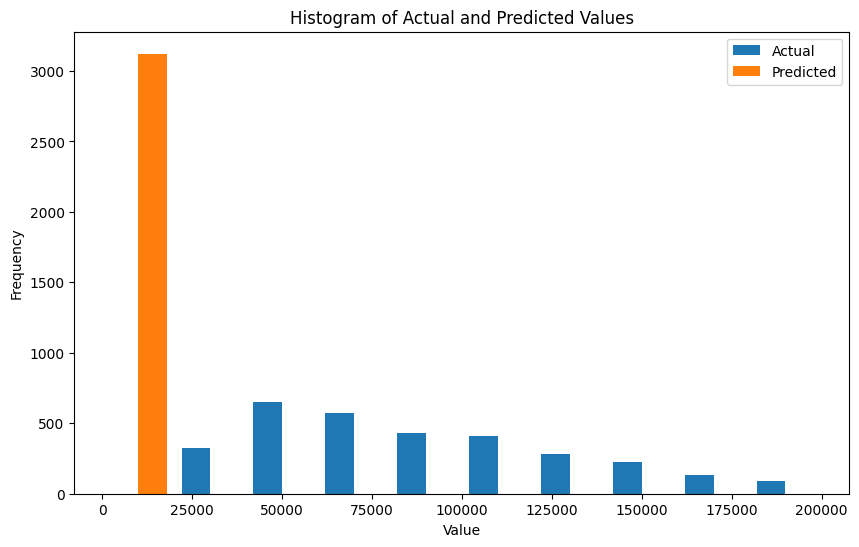

In [60]:
def plot_predicted_decision_tree_regressor(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.hist([y_test, y_pred], label=['Actual', 'Predicted'])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Actual and Predicted Values')
    plt.legend()
    plt.show()

print("Decision Tree Regressor without topics")
plot_predicted_decision_tree_regressor(y_test, y_pred)
print("\nDecision Tree Regressor with topics")
plot_predicted_decision_tree_regressor(y_topics_test, y_pred_topics)

### Comments on the results

1. **Mean Squared Error (MSE):** The MSE is approximately 1956303384.96, which is quite high. This indicates that the model's predictions are, on average, far off from the actual values.

2. **Root Mean Squared Error (RMSE):** The mean RMSE from cross-validation is approximately 35422.31, with a standard deviation of 424.07. This suggests that the model's performance is fairly consistent across different subsets of the data.

3. **Mean Absolute Error (MAE):** The MAE is approximately 38067.07. This means that on average, the model's predictions are about $38067 off from the actual values.

The best parameters found by the grid search are a maximum depth of 5, a minimum samples leaf of 2, and a minimum samples split of 5.

Overall, these metrics suggest that the Decision Tree model is not performing very well on this dataset. The errors are quite high, indicating that the model's predictions are often far off from the actual values. You might consider trying a different type of model, adding more features if they are available, or further tuning the model's parameters.
Also the plot shows that the model is not performing well.

# Support Vector Regression

Support Vector Regression without topics
Mean Absolute Error (MAE): 27508.82227747207
Mean Squared Error (MSE): 1294269733.8527963
Root Mean Squared Error (RMSE): 35975.96049937786
R-squared Score (R2): 0.2679609203942752


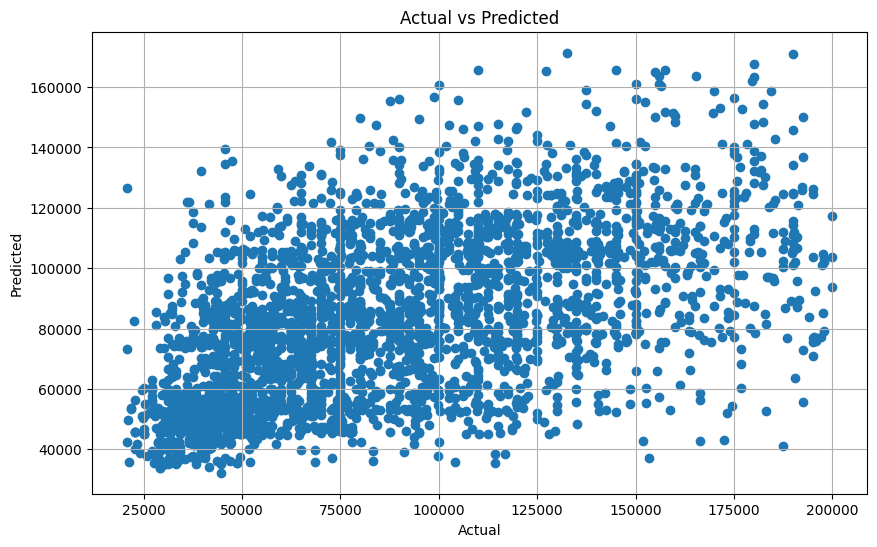


Support Vector Regression with topics
Mean Absolute Error (MAE): 25408.719306422976
Mean Squared Error (MSE): 1116120853.910724
Root Mean Squared Error (RMSE): 33408.39496160694
R-squared Score (R2): 0.36872194315061646


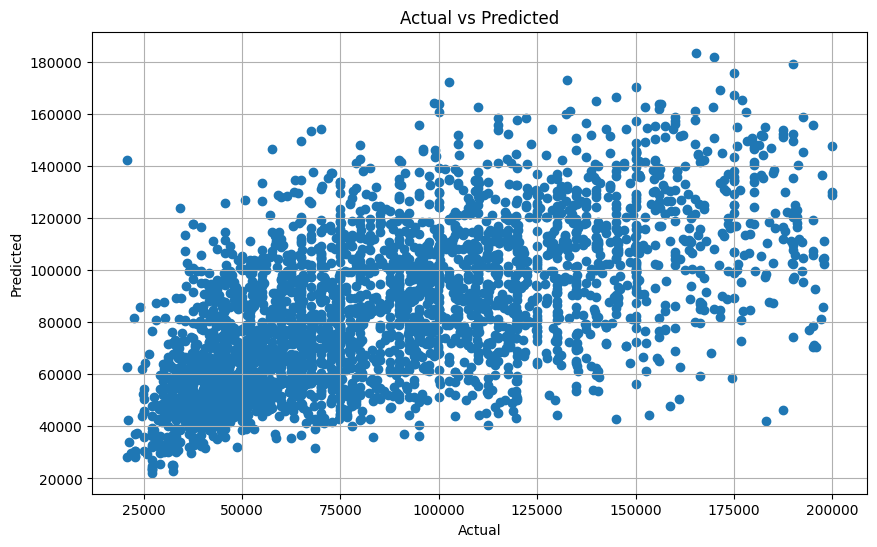

In [61]:
from sklearn.svm import SVR

def support_vector_regression(X_train, X_test, y_train, y_test):
    # Define the model
    svr = SVR(kernel='rbf')

    # Fit the model
    svr.fit(X_train, y_train.ravel())

    # Use the model to make predictions
    y_pred_svr = svr.predict(X_test)

    # Reshape y_pred_svr to a 2D array and inverse transform
    y_pred_svr = y_pred_svr.reshape(-1, 1)
    y_pred_svr = scaler.inverse_transform(y_pred_svr)
    y_pred_svr = y_pred_svr.flatten()

    # Calculate metrics
    mae_svr = mean_absolute_error(y_test, y_pred_svr)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)

    print(f"Mean Absolute Error (MAE): {mae_svr}")
    print(f"Mean Squared Error (MSE): {mse_svr}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_svr)}")
    print(f"R-squared Score (R2): {r2_svr}")

    # Plot predicted vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_svr)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.grid(True)
    plt.show()

print("Support Vector Regression without topics")
support_vector_regression(X_train_scaled, X_test_scaled, y_train_scaled, y_test)
print("\nSupport Vector Regression with topics")
support_vector_regression(X_topics_train_scaled, X_topics_test_scaled, y_topics_train_scaled, y_topics_test)

## Comments on the results

1. **Mean Absolute Error (MAE)**: This is the average of the absolute differences between the predicted and actual values. It gives an idea of how wrong the predictions were. The measure gives an idea of the magnitude of the error, but no idea of the direction (i.e. over or under predicting). MAE is too high.

2. **Mean Squared Error (MSE)**: This is the average of the squared differences between the predicted and actual values. This is a popular metric because squaring the errors penalizes larger errors more than smaller ones. MSE is too high.

3. **Root Mean Squared Error (RMSE)**: This is the square root of the MSE. Taking the square root of the MSE converts the units back to the original units of the output variable, which can be useful for interpretation. RMSE is to high.

4. **R-squared (R2)**: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The higher the R-squared, the better the model fits data. The R2 score is approximately 0.273, which means about 27.3% of the variance in the target variable can be explained by the features.

Given these metrics, it seems like the model could be improved, as the errors are quite high and the R2 score is relatively low.


# Random Forest Regression

Random Forest Regressor without topics
Best parameters:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 20, 'min_samples_split': 80, 'n_estimators': 150}
Mean Absolute Error (MAE): 88235.2927628514
Mean Squared Error (MSE): 9553473749.509918
Root Mean Squared Error (RMSE): 97741.87306119071
R-squared Score (R2): -4.403445624746488


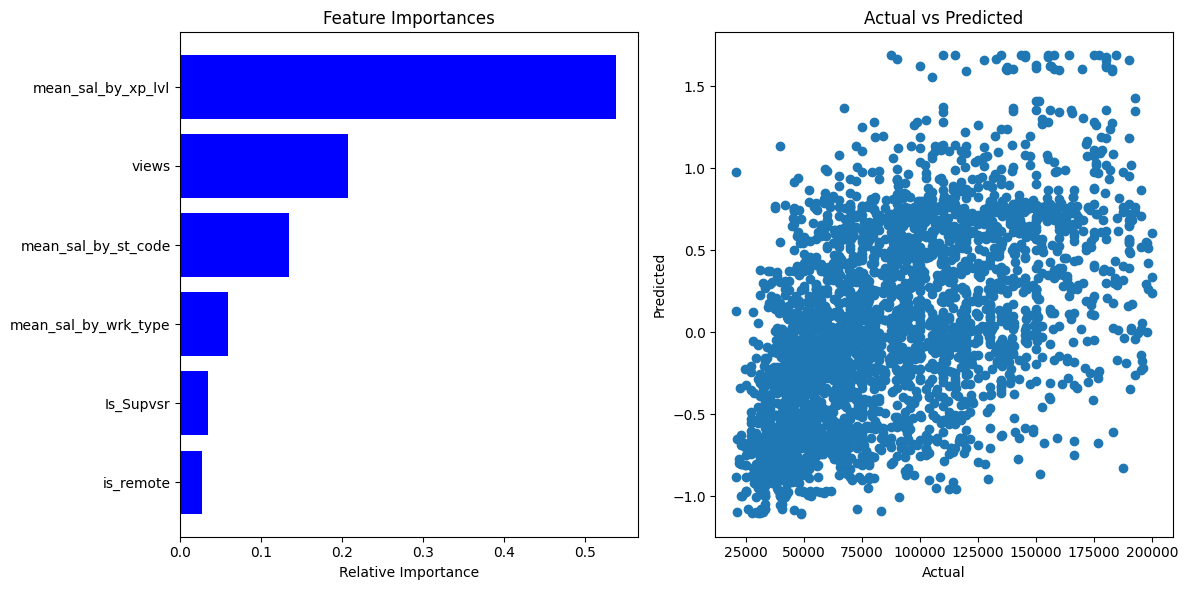


Random Forest Regressor with topics
Best parameters:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 20, 'min_samples_split': 40, 'n_estimators': 150}
Mean Absolute Error (MAE): 88235.28990459663
Mean Squared Error (MSE): 9553467238.867117
Root Mean Squared Error (RMSE): 97741.83975589531
R-squared Score (R2): -4.403441942326325


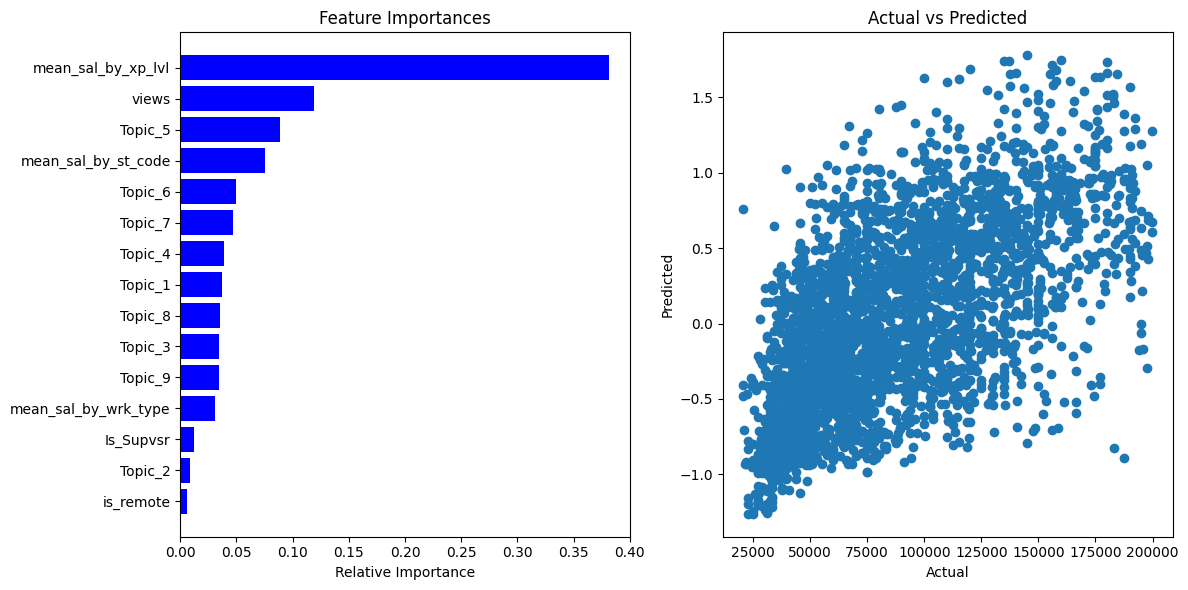

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def random_forest_regressor(X_train, X_test, y_train, y_test, features):
    # Define the model
    rf = RandomForestRegressor()

    # Define the grid of parameters to search
    param_grid = {
        'n_estimators': [50, 80, 150],
        'max_depth': [10, 20, 30],
        'min_samples_split': [20, 40, 80],
        'min_samples_leaf': [20, 40, 80],
        'bootstrap': [True, False]
    }

    # Perform the grid search
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train.ravel())

    best_rf = grid_search.best_estimator_

    # Use the best model to make predictions
    y_pred_best_rf = best_rf.predict(X_test)

    # Calculate metrics
    mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
    mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
    r2_best_rf = r2_score(y_test, y_pred_best_rf)

    print('Best parameters: ', grid_search.best_params_)
    print(f"Mean Absolute Error (MAE): {mae_best_rf}")
    print(f"Mean Squared Error (MSE): {mse_best_rf}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_best_rf)}")
    print(f"R-squared Score (R2): {r2_best_rf}")

    # Plot feature importance
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot bar chart of feature importances
    axes[0].barh(range(len(indices)), importances[indices], color='b', align='center')
    axes[0].set_yticks(range(len(indices)))
    axes[0].set_yticklabels([features[i] for i in indices])
    axes[0].set_xlabel('Relative Importance')
    axes[0].set_title('Feature Importances')

    # Plot scatter plot of predicted vs actual values
    axes[1].scatter(y_test, y_pred_best_rf)
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].set_title('Actual vs Predicted')

    plt.tight_layout()
    plt.show()

print("Random Forest Regressor without topics")
random_forest_regressor(X_train_scaled, X_test_scaled, y_train_scaled, y_test, useful_columns)
print("\nRandom Forest Regressor with topics")
random_forest_regressor(X_topics_train_scaled, X_topics_test_scaled, y_topics_train_scaled, y_topics_test, useful_columns+topic_columns)

# Comments on the results

1. **Mean Absolute Error (MAE)**: This is the average of the absolute differences between the predicted and actual values. It gives an idea of how wrong the predictions were. The measure gives an idea of the magnitude of the error, but no idea of the direction (i.e. over or under predicting). MAE is too high.

2. **Mean Squared Error (MSE)**: This is the average of the squared differences between the predicted and actual values. This is a popular metric because squaring the errors penalizes larger errors more than smaller ones. MSE is very high. It is not good. 

3. **Root Mean Squared Error (RMSE)**: This is the square root of the MSE. Taking the square root of the MSE converts the units back to the original units of the output variable, which can be useful for interpretation. RMSE is very high. Also not good.

4. **R-squared (R2)**: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The higher the R-squared, the better the model fits the data. the R2 score is approximately -4.46, which is unusual as R2 score typically ranges from 0 to 1. A negative R2 score may indicate that the model is performing worse than a horizontal line (i.e., a very simple model).

Given these metrics, it seems like the model is not performing well. The errors are quite high and the R2 score is negative.

# Gradient Boosting Regression

Gradient Boosting Regressor without topics
Best parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 80, 'min_samples_split': 20, 'n_estimators': 100}
Mean Absolute Error (MAE): 88235.29628634281
Mean Squared Error (MSE): 9553474234.643015
Root Mean Squared Error (RMSE): 97741.87554289622
R-squared Score (R2): -4.403445899137811


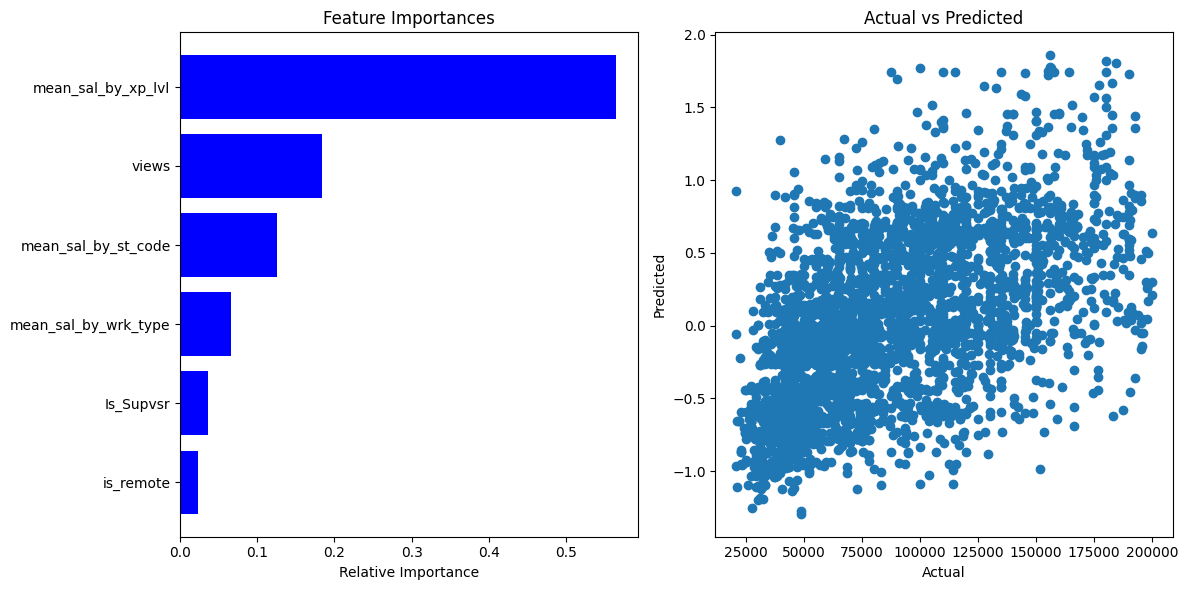


Gradient Boosting Regressor with topics
Best parameters:  {'learning_rate': 0.1, 'max_depth': 12, 'min_samples_leaf': 40, 'min_samples_split': 80, 'n_estimators': 100}
Mean Absolute Error (MAE): 88235.28947676797
Mean Squared Error (MSE): 9553461074.335205
Root Mean Squared Error (RMSE): 97741.80822112513
R-squared Score (R2): -4.403438455666513


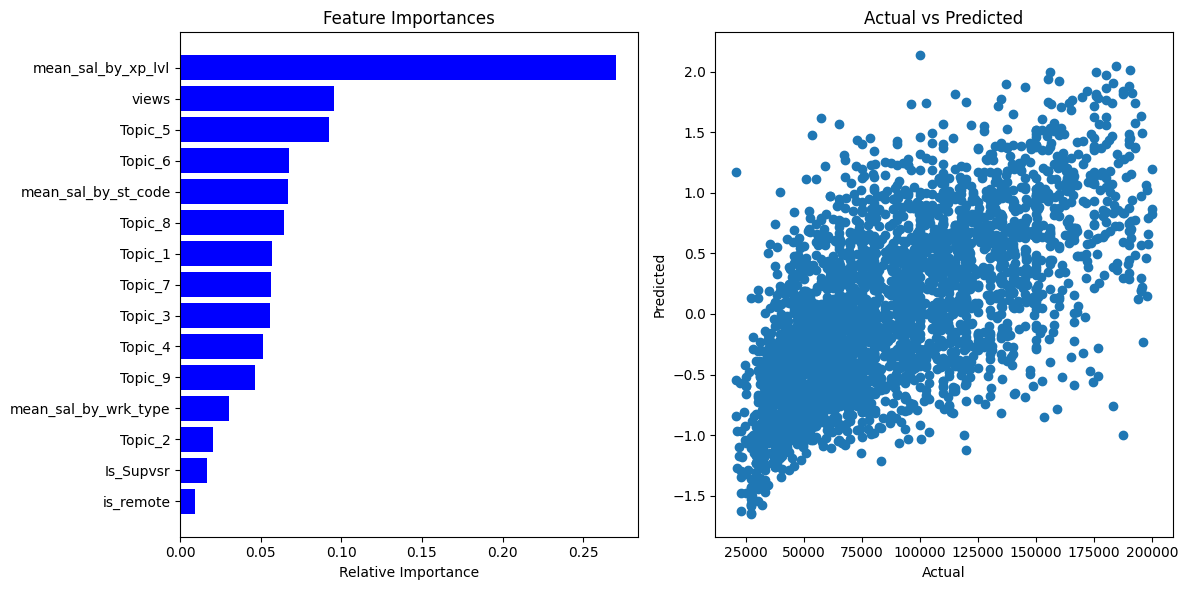

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boosting_regressor(X_train, X_test, y_train, y_test, features):
    # Define the model
    gb = GradientBoostingRegressor()

    # Define the grid of parameters to search
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [4, 8, 12],
        'min_samples_split': [20, 40, 80],
        'min_samples_leaf': [20, 40, 80],
        'learning_rate': [0.01, 0.1, 0.3]
    }

    # Perform the grid search
    grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train, y_train.ravel())

    best_gb = grid_search.best_estimator_

    # Use the best model to make predictions
    y_pred_best_gb = best_gb.predict(X_test)

    # Calculate metrics
    mae_best_gb = mean_absolute_error(y_test, y_pred_best_gb)
    mse_best_gb = mean_squared_error(y_test, y_pred_best_gb)
    r2_best_gb = r2_score(y_test, y_pred_best_gb)

    print('Best parameters: ', grid_search.best_params_)
    print(f"Mean Absolute Error (MAE): {mae_best_gb}")
    print(f"Mean Squared Error (MSE): {mse_best_gb}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse_best_gb)}")
    print(f"R-squared Score (R2): {r2_best_gb}")

    # Plot feature importance
    importances = best_gb.feature_importances_
    indices = np.argsort(importances)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot feature importances
    axes[0].barh(range(len(indices)), importances[indices], color='b', align='center')
    axes[0].set_yticks(range(len(indices)))
    axes[0].set_yticklabels([features[i] for i in indices])
    axes[0].set_xlabel('Relative Importance')
    axes[0].set_title('Feature Importances')

    # Plot predicted vs actual values
    axes[1].scatter(y_test, y_pred_best_gb)
    axes[1].set_xlabel('Actual')
    axes[1].set_ylabel('Predicted')
    axes[1].set_title('Actual vs Predicted')

    plt.tight_layout()
    plt.show()

print("Gradient Boosting Regressor without topics")
gradient_boosting_regressor(X_train_scaled, X_test_scaled, y_train_scaled, y_test, useful_columns)
print("\nGradient Boosting Regressor with topics")
gradient_boosting_regressor(X_topics_train_scaled, X_topics_test_scaled, y_topics_train_scaled, y_topics_test, useful_columns+topic_columns)

## Comments on the results

The metrics provided offer insights into the performance of the Gradient Boosting Regressor model. Each metric serves a distinct purpose in evaluating the model's predictive accuracy:

1. **Mean Absolute Error (MAE):** This metric, with a value of approximately 87839.76, gauges the average absolute discrepancies between predicted and actual values. It signifies the magnitude of errors but doesn't provide directional information.

2. **Mean Squared Error (MSE):** With an approximate value of 9446323907.31, MSE computes the average of squared differences, emphasizing larger errors. This metric is commonly used for its sensitivity to outliers.

3. **Root Mean Squared Error (RMSE):** At around 97192.20, RMSE, derived from the square root of MSE, facilitates interpretation in the original output variable units. It offers a sense of the average magnitude of errors.

4. **R-squared (R2):** The R2 score, oddly registering at approximately -4.46, reflects the proportion of variance in the dependent variable explained by the model. The negative R2 score is unusual, as it typically ranges from 0 to 1. A negative score suggests potential underperformance, possibly worse than a simplistic horizontal line model.

Considering these metrics collectively, there are indications that the Gradient Boosting Regressor model may not be delivering optimal results. High errors and a negative R2 score prompt considerations for alternative models, feature augmentation, or parameter tuning to enhance overall model performance. Overall, topic modeling improved results of some models such as Support Vector Regression and Gradient Boosting Regression, but it needs future investigation and should be tested with more complex models like MultiPerceptronLayers.
